In [2]:
import numpy as np 
import gymnasium as gym
import random
import torch
import torch.nn as nn
from collections import deque
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
''' Notes :
>In PyTorch, a tensor is similar to a multi-dimensional array and is the fundamental data structure used for storing data in neural networks.

> zip(*batch) creates tuples, and torch.tensor() struggles with tuples.
>> zip(*batch) returns a zip object (iterator), which is not a valid input for torch.tensor(). 
    PyTorch expects a list, tuple, or NumPy array, not an iterator.
np.array() ensures correct conversion to tensor-friendly lists.( therefore first conver to numpy array then to tensor )


>No activation function in the output layer since  Q-values should be unbounded

> requires_grad=False ensures that PyTorch does not track gradients for state_tensor
   By default, PyTorch tracks operations on tensors to support automatic differentiation (used in backward()).
     You set requires_grad=True only for learnable parameters in neural networks.

> torch.unsqueeze(dim) adds a new dimension at the specified index dim
    .unsqueeze(0) → Adds a new dimension at the 0th index (batch dimension).

>> when feeding a feature vector (state representation) into a PyTorch neural network, the correct shape is:
    * Feed input as a batch → Shape should be (batch_size, num_features).
    * Even if using a single sample → Use (1, num_features), not (num_features, 1).
    * For CNNs, add channel dimensions: (batch_size, channels, height, width), e.g., (1, 3, 224, 224) for an RGB image.

>when i write forward propagation inside class using pytorch ,  the final result of ouput layer is returned as tensor array.

>target_model.load_state_dict(self.model.state_dict()):
This line copies the parameters of the policy network (self.model) and loads them into the target network (self.target_model). 
Essentially, this makes the target network a copy of the policy network.

> tensor.gather(dim, index) function in PyTorch is used to gather values along a specified axis (dimension) based on a set of indices. 
   It allows you to select specific elements from a tensor according to the indices [ dim =1 --> along columns ( x axis) , dim=0 --> along rows (y axis)]

> .max(1, keepdim=True) --> 1 signifies the direction along which maximum  to be found.
   using keepdim=True ensures the shape remains (batch_size,1) or else resulting tensor would be reduced to one dimension 
    also, .max() func returns a tuple of :
                        The maximum Q-values for each next state.
                        The indices of the actions that provide those maximum Q-values.

> Extracting a single value from a tensor: 
        If a tensor contains only one element, 
        you can use .item() to get that value as a native Python data type (such as int, float, etc.), 








'''

' Notes :\n>In PyTorch, a tensor is similar to a multi-dimensional array and is the fundamental data structure used for storing data in neural networks.\n\n> zip(*batch) creates tuples, and torch.tensor() struggles with tuples.\n>> zip(*batch) returns a zip object (iterator), which is not a valid input for torch.tensor(). \n    PyTorch expects a list, tuple, or NumPy array, not an iterator.\nnp.array() ensures correct conversion to tensor-friendly lists.( therefore first conver to numpy array then to tensor )\n\n\n>No activation function in the output layer since  Q-values should be unbounded\n\n> requires_grad=False ensures that PyTorch does not track gradients for state_tensor\n   By default, PyTorch tracks operations on tensors to support automatic differentiation (used in backward()).\n     You set requires_grad=True only for learnable parameters in neural networks.\n\n> torch.unsqueeze(dim) adds a new dimension at the specified index dim\n    .unsqueeze(0) → Adds a new dimension a

In [ ]:
'''
DQN : since for continuous state space ; we stuggled in making look up Q tables since there can be infinite possibilities of state.
      Now for any state for getting/approximating its q value we sigly use function approximator
      NN is a great function approximator.
      So we estimate Q values corresponding to every possible action for any number of states using a neural network model.

      In NN - forward propagation and backward propagation.
        forward propagation for getting the output of NN ( here q values )
        then we want to update those q values for wach of the action as per the feedback we got ; here we use backward propagation.
        we compute the loss b/w this o/p q value and expected q value (target in bellman optimality)

        updating o/p --> updating NN --> updating parameters of each layes wrt to minimizing that loss.

        in this we we keep doing this and achieve convergence.
'''

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        return (torch.tensor(np.array(states), dtype=torch.float32),
                torch.tensor(actions, dtype=torch.int64).unsqueeze(1),
                torch.tensor(rewards, dtype=torch.float32).unsqueeze(1),
                torch.tensor(np.array(next_states), dtype=torch.float32),
                torch.tensor(dones, dtype=torch.int64).unsqueeze(1))  # Fixed dtype

    def size(self):
        return len(self.buffer)


In [4]:
class DQN_nn(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN_nn, self).__init__()
        self.layer1 = nn.Linear(state_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, action_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.output(x) 
        return x
                

In [ ]:
class DQN_agent():
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=0.0001, batch_size=64, buffer_size=10000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = ReplayBuffer(buffer_size)

        self.model = DQN_nn(state_dim, action_dim)
        self.target_model = DQN_nn(state_dim, action_dim)
        self.target_model.load_state_dict(self.model.state_dict())

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.epsilon = 1.0  
        self.epsilon_decay = 0.995  
        self.epsilon_min = 0.1  

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, requires_grad=False).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
                return torch.argmax(q_values).item()

    def update(self):
        if self.memory.size() < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        q_values = self.model(states).gather(1, actions) # dim(states) = (batch_size,state_dim) 
        #.gather()to get q values corresponding to particular action in actions

        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1, keepdim=True)[0]
            targets = rewards + self.gamma * next_q_values * (1 - dones)  

        loss = self.loss_fn(q_values, targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

In [6]:
env = gym.make("CartPole-v1")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQN_agent(state_dim, action_dim)

episodes = 500
max_steps = 200
target_update_freq = 10
reward_history = []

for episode in range(episodes):
    state, _ = env.reset() 
    total_reward = 0

    for t in range(max_steps):
        action = agent.select_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated  

        agent.memory.store(state, action, reward, next_state, done)

        agent.update()

        state = next_state
        total_reward += reward

        if done:
            break

    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

    if episode % target_update_freq == 0:
        agent.update_target_network()

    reward_history.append(total_reward)
    print(f"Episode {episode}: Reward = {total_reward}")

env.close()

Episode 0: Reward = 43.0
Episode 1: Reward = 18.0
Episode 2: Reward = 22.0
Episode 3: Reward = 17.0
Episode 4: Reward = 19.0
Episode 5: Reward = 18.0
Episode 6: Reward = 12.0
Episode 7: Reward = 19.0
Episode 8: Reward = 17.0
Episode 9: Reward = 24.0
Episode 10: Reward = 13.0
Episode 11: Reward = 41.0
Episode 12: Reward = 13.0
Episode 13: Reward = 51.0
Episode 14: Reward = 25.0
Episode 15: Reward = 13.0
Episode 16: Reward = 20.0
Episode 17: Reward = 13.0
Episode 18: Reward = 32.0
Episode 19: Reward = 43.0
Episode 20: Reward = 12.0
Episode 21: Reward = 41.0
Episode 22: Reward = 18.0
Episode 23: Reward = 27.0
Episode 24: Reward = 19.0
Episode 25: Reward = 17.0
Episode 26: Reward = 14.0
Episode 27: Reward = 29.0
Episode 28: Reward = 12.0
Episode 29: Reward = 38.0
Episode 30: Reward = 26.0
Episode 31: Reward = 15.0
Episode 32: Reward = 12.0
Episode 33: Reward = 15.0
Episode 34: Reward = 14.0
Episode 35: Reward = 43.0
Episode 36: Reward = 20.0
Episode 37: Reward = 38.0
Episode 38: Reward = 1

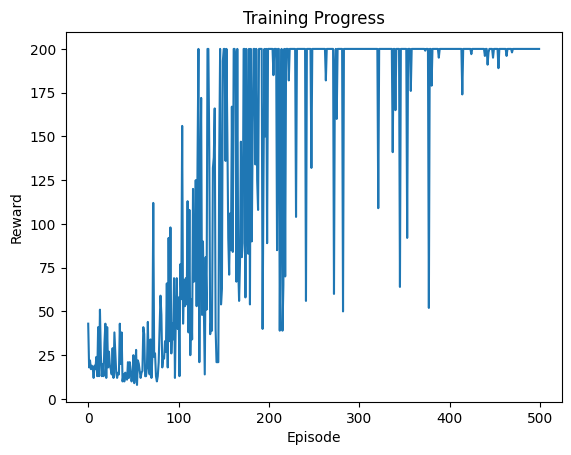

In [7]:
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(reward_history)
plt.show()


c:\Users\akash\OneDrive\Documents\Desktop\iv labs\drl_envs_tasks\myenv\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:250: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


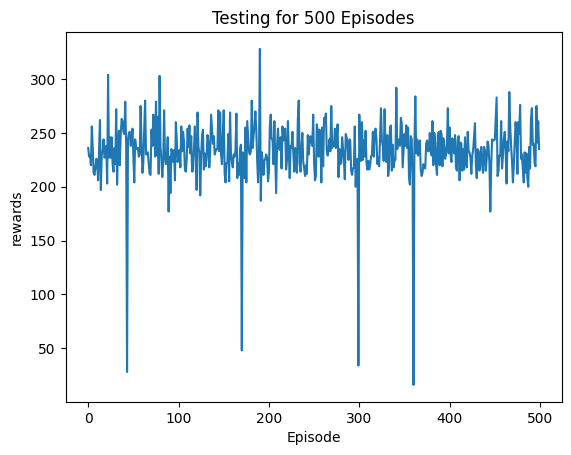

Final Score: 235.0


In [8]:
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")
return_history = []
epi_num=500
for episode in range(epi_num):
    state, _ = env.reset()  
    done = False
    total_reward = 0

    while not done:
        env.render()  
        action = agent.select_action(state)  
        state, reward, done, _, _ = env.step(action)  
        total_reward += reward

    return_history.append(total_reward)  

env.close() 

plt.title(f"Testing for {epi_num} Episodes")
plt.xlabel("Episode")
plt.ylabel("rewards")
plt.plot(return_history)
plt.show()

print("Final Score:", total_reward)  # Print the final reward of the last episode

plt.show()

In [9]:
env = gym.make("CartPole-v1",render_mode='human')
state = env.reset()[0]
done = False
total_reward = 0

while not done:
    env.render()
    action = agent.select_action(state)  # Use trained policy
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print("Final Score:", total_reward)

Final Score: 215.0
